In [13]:
import skimage
import matplotlib.pyplot as plt
from pathlib import Path
from os import walk
import numpy as np

In [168]:
DATASET = Path('Dataset/Labelled')

def get_label(file_name: str) -> tuple[int, int, int, int, int]:
    tokens = file_name.split('_')
    digit = tokens[0]
    sum = tokens[1]
    borders = tokens[2]
    top, bottom, left, right = borders
    return (digit, sum, top, bottom, left, right)

def fetch_images():
    for root, dirs, files in walk(DATASET):
        print(root, dirs, files)
        for file in files:
            file_path = Path(root)/file
            image = skimage.io.imread(file_path)
            gray = skimage.color.rgb2gray(image)
            label = get_label(file)
            yield (gray, label)

def image_show(image: np.ndarray, *args, **kwargs) -> None:
    plt.imshow(image, *args, **kwargs)
    plt.xticks([])
    plt.yticks([])

dataset = fetch_images()

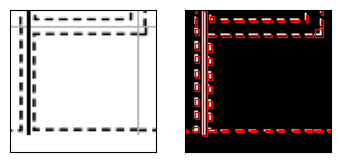

dict_values(['0', 0, True, True, True, False]) ('0', '0', '1', '1', '1', '0')


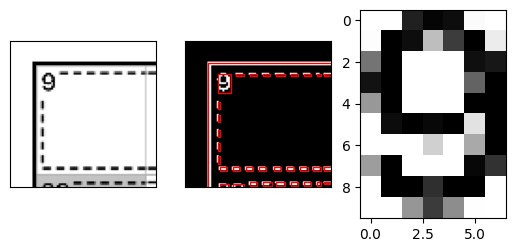

dict_values(['0', 1, True, True, True, False]) ('0', '9', '1', '1', '1', '0')


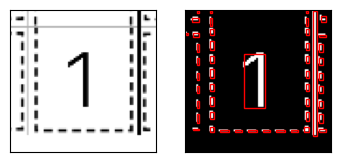

dict_values([1, 0, False, True, True, True]) ('1', '0', '0', '1', '1', '1')


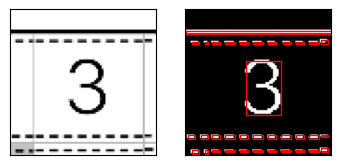

dict_values([1, 0, True, True, False, False]) ('3', '0', '1', '1', '0', '0')


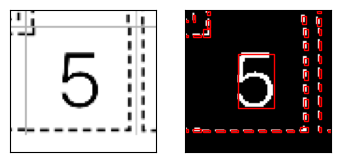

dict_values([1, 0, False, True, False, True]) ('5', '0', '0', '1', '0', '1')


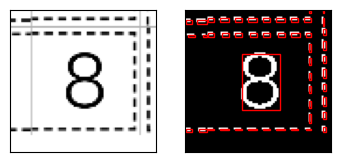

dict_values([1, 0, True, True, False, True]) ('8', '0', '1', '1', '0', '1')


In [171]:
for image, label in fetch_images():
    output = {'digit': '0', 'sum': 0, 'top_border': False, 'bottom_border': False, 'left_border': False, 'right_border': False}
    thresholds = skimage.filters.threshold_multiotsu(image)
    regions = np.digitize(image, bins=thresholds)
    mask = (regions == 0).astype(int)

    plt.subplot(1,3,1)
    image_show(image, cmap='gray')
    plt.subplot(1, 3, 2)
    image_show(mask, cmap='gray')

    labelled_image = skimage.measure.label(mask)
    roi = skimage.measure.regionprops(labelled_image)
    roi.sort(key=lambda x: (x.bbox[1], x.bbox[0]))
    for region in roi:
        ymin, xmin, ymax, xmax = region.bbox
        area = region.num_pixels
        h, w = image.shape
        width, height = xmax - xmin, ymax - ymin
        if ymin <= h // 2 <= ymax and xmin <= w // 2 <= xmax and width < w // 2:
            # bounding box about center
            # feed regions[region.slice] into OCR
            output['digit'] = 1
        elif width / height > 1.5 and width < w // 2 and w // 4 < xmin <= xmax < 3 * w // 4: # horizontal dotted line
            if ymin < h // 2: # top border
                output['top_border'] = True
            else:
                output['bottom_border'] = True
        elif height / width > 1.5 and height < h // 2 and h // 4 < ymin <= ymax < 3 * h // 4: # vertical dotted line
            if xmin < w // 2: # left border
                output['left_border'] = True
            else:
                output['right_border'] = True
        elif xmax < w // 2 and ymax < h // 2 and area > 10 and 1/2 < height / width < 2: # top left corner
            output['sum'] *= 10
            output['sum'] += int(1) # OCR-ed value
            plt.subplot(1,3,3)
            plt.imshow(image[region.slice], cmap='gray')
            plt.subplot(1,3,2)

        rect = plt.Rectangle((xmin, ymin), width, height, edgecolor='red', fill=False)
        plt.gca().add_patch(rect)

    plt.show()
    print(output.values(), label)

In [162]:
output

{'digit': '0',
 'sum': 1,
 'top_border': True,
 'bottom_border': True,
 'left_border': True,
 'right_border': False}